# Deconvolution
For already mean combined, telescope and unresolved corrected data

Correction for PSF smearing will be after! 

16.08.2024 - I do not use boundary condition any more and use the cutted version of the PSF as it allows to avoid niases caused by detector features in the PSF image that are not part of the actual star image. I also use a region of 112 pixels (~400 mas) from the center to calculate difference between iterations 


Current set up is for ZIMPOL data, but can be used for IRDIS as well by changing path, filenames and mas/pixel value


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits

from scipy.signal import convolve2d
from scipy.signal import convolve, oaconvolve
from PIL import Image, ImageChops
from astropy.convolution import convolve_fft

import sys

## Functions

In [2]:
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference
    
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)  

    return m_norm

def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(dir,qfile)
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for IRDIS
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

## Star Set up

In [10]:

# stars=['AR_Pup_dc_notnorm','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya']
stars=['01.SCI_AR_Pup']
stars=['01.SCI_UMon']


stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','REF_HD75885':'ref', '01.SCI_AR_Pup':'sci','UMon':'sci','01.SCI_UMon':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','REF_HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}

ref_of_sci={'01.SCI_AR_Pup':'01.SCI_AR_Pup','UMon':'HD71253','01.SCI_UMon':'01.SCI_UMon','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals

fittypes=['Q_phi'] # refers to intensities 'I','PI','Q_phi'
#otherfittype=['I_pol']

# bands=['I','V']
bands=["H"]

N_decon = 15
camera = 'IRDIS'
# camera = 'ZIMPOL'

In [11]:
def create_dir(dirname):
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    return dirname

## Deconvolution

At this point, create the different cameras folders in the data (Unres+PSFcorr) and transfer

In [12]:
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'

for star in stars:
    print(star)
    critlim=0.02
    if star =='V709_Car': critlim=0.05

    # dirdat =dirdat0+star+'/Unres+PSFcorr/'+'ZIMPOL'+'/'
    dirdat =dirdat0+star+'/Unres+PSFcorr/'+camera+'/'
    print()

    for band in bands:

        # create directory
        dirName1=dirdat0+star+'/Deconvolution_corr_tel+unres/'+camera+'/'
        create_dir(dirName1)

        # do deconvolution for each filter
        for fittype in fittypes:
            dirName=dirName1+'deconvolved_'+fittype+'/'
            create_dir(dirName)

            image=[]
            PSF=[]
            # ps=3.6
            ps=12.27

            # load image data
            if fittype=='I':
                image, n=Loadimages(star,fittype,dirdat,band,'_meancombined')
            elif fittype=='PSF':
                image,n=Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band)
            else:
                image, n=Loadimages(star,fittype,dirdat,band,'_corr_tel+unres')

            # image, n=Loadimages(star,fittype,dirdat,band,'_meancombined') #+PSF_smear
            print(ref_of_sci[star])
            # image,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band)
            PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+camera+'/',band)

            print(n)

            # crop image
            a=int(300)#int(n/2.-20*ps)
            b=int(n-300)#int(n/2.+20*ps)
            psf=PSF[a:b,a:b]
            image=image#[a:b,a:b]

            # create grid
            x = np.linspace(-n/2., n/2., num=n)
            y = np.linspace(-n/2., n/2., num=n)
            x0 = 0.5
            y0 = 0.5
            x = x-x0
            y = y-y0
            X, Y = np.meshgrid(x, y)
            R = np.sqrt(X**2 + Y**2)

            lim=30

            print("Image shape:", image.shape)
            print("Image max:", np.max(image))
            print("Image min:", np.min(image))
            print("PSF shape:", psf.shape)
            print("PSF max:", np.max(psf))
            print("PSF min:", np.min(psf))

            # plot images
            plotImage(image, lim)
            plt.savefig(dirName+ star +"_"+band+"_"+fittype+"_image.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()

            plotImage(psf, lim)
            plt.savefig(dirName+star +"_"+band+ "_PSF.png",bbox_inches='tight', pad_inches=0.1)
            plt.close()
            #adc=int(n/2.-10*ps)
            #bdc=int(n/2.+10*ps)

            # perform deconv
            psf_fliped=np.flip(psf)
            decon = np.copy(image)  # Create starting file for first iteration of deconvolution.  For the very first step, we use the original file as it’s own deconvolution
            for i in range(0, N_decon):  # now iterate
                # print ('deconvolution step ' + str(i))  # just some control output
                print(f"Deconvolution step {i}")
                print(f"  Image shape: {image.shape}, max: {np.max(image)}, min: {np.min(image)}")
                print(f"  PSF shape: {psf.shape}, max: {np.max(psf)}, min: {np.min(psf)}")
                print(f"  Decon shape: {decon.shape}, max: {np.max(decon)}, min: {np.min(decon)}")
                print(f"  psf_fliped shape: {psf_fliped.shape}, max: {np.max(psf_fliped)}, min: {np.min(psf_fliped)}")

                decon = decon *(convolve_fft(image / convolve_fft(decon, psf), psf_fliped))# (convolve_fft(image / convolve_fft(decon, psf, boundary='wrap'), psf_fliped, boundary='wrap'))
                plotImage(decon, lim)

                if i<=9:
                    plt.savefig(dirName+star +"_"+band+'_0'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                else:
                    plt.savefig(dirName+star +"_"+band+'_'+str(i) +"_"+fittype+"_decon2d.png",bbox_inches='tight', pad_inches=0.1)
                plt.close()
                if i==0:
                    deconvolved1=decon
                    crit=1

                if i>=1:
                    crit=compare(decon[a:b,a:b],deconvolved1[a:b,a:b])
                    #crit = np.sum(ImageChops.difference(decon[adc:bdc,adc:bdc],deconvolved1[adc:bdc,adc:bdc]))/np.sum(decon[adc:bdc,adc:bdc])
                    #crit=abs(np.sum((decon[adc:bdc,adc:bdc]-deconvolved1[adc:bdc,adc:bdc])**2.)/np.sum(decon[adc:bdc,adc:bdc]**2))
                print(crit)
                deconvolved1=decon

                if fittype!='PSF':
                    if (crit<critlim):
                        N_final=i
                        break

            # This above is the implementation of the basic equation for the Richardson-Lucy deconvolution.
            # Note the np.fliplr and np.flipud functions which are required due to the quirks of numerical Fourier transformation.
            # I don’t remember the details of the specific implementation here, e.g., why I had to flip for the outer convolution but not for the inner one.
            # Probably becomes clear from a close look at the documentation of the convolve2d function.


            out_fits = fits.HDUList(fits.PrimaryHDU(decon))                  # create output fits structure
            out_fits.writeto(dirName+star+'_'+band+'_decon.fits', overwrite = True)                       # write output

01.SCI_UMon

/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Unres+PSFcorr/IRDIS/ 01.SCI_UMon_H_Q_phi_corr_tel+unres.fits
01.SCI_UMon_H_Q_phi_corr_tel+unres.fits
0.0003385593581415474
01.SCI_UMon
1024
1024
Image shape: (1024, 1024)
Image max: 63.60514485393226
Image min: -211.06597733662798
PSF shape: (424, 424)
PSF max: 34754.953
PSF min: -1036.3107
Deconvolution step 0
  Image shape: (1024, 1024), max: 63.60514485393226, min: -211.06597733662798
  PSF shape: (424, 424), max: 34754.953125, min: -1036.3106689453125
  Decon shape: (1024, 1024), max: 63.60514485393226, min: -211.06597733662798
  psf_fliped shape: (424, 424), max: 34754.953125, min: -1036.3106689453125
1
Deconvolution step 1
  Image shape: (1024, 1024), max: 63.60514485393226, min: -211.06597733662798
  PSF shape: (424, 424), max: 34754.953125, min: -1036.3106689453125
  Decon shape: (1024, 1024), max: 12036.699131947798, min: -9858.421630552666
  psf_fliped shape: (424, 424), max: 34754.953125, min

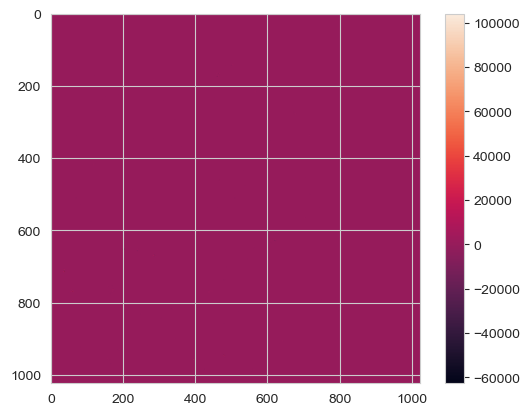

In [14]:
hdul = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_UMon/Deconvolution_corr_tel+unres/IRDIS/deconvolved_Q_phi/01.SCI_UMon_H_decon.fits') #replace with your file name
hdu = hdul[0]

image_data = hdu.data

if image_data is not None:
    plt.imshow(image_data)
    plt.colorbar()  # Optional: Add a colorbar
    plt.show()
else:
    print("PrimaryHDU contains no image data.")

hdul.close() #close the fits file.

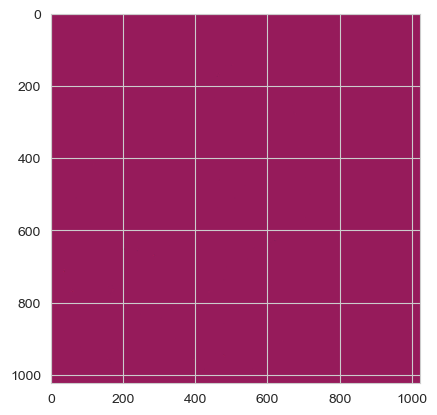

In [15]:
plt.imshow(deconvolved1)

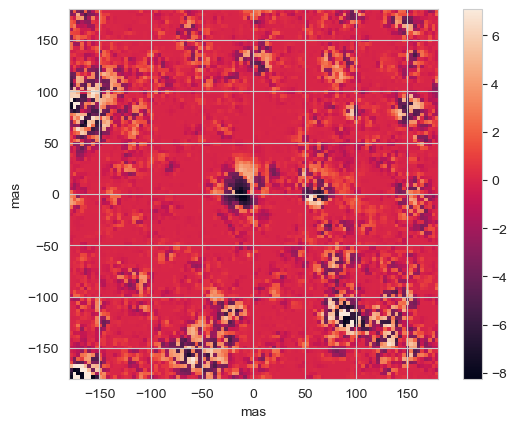

In [17]:
plotImage(deconvolved1,50)